In [1]:
import re
import gc
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import mode
import scipy.stats as stats

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgb
from lightgbm import plot_importance

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [3]:
df_train.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


In [4]:
df_test.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1
0,6544e41a8817,dbe73ad6e4b5,Волгоградская область,Волгоград,Личные вещи,Детская одежда и обувь,Для мальчиков,Обувь,25,Отдам бесплатно,На ангарском,NaN,66,2017-04-18,Private,a8b57acb5ab304f9c331ac7a074219aed4d349d8aef386...,2020.0
1,65b9484d670f,2e11806abe57,Свердловская область,Нижняя Тура,Хобби и отдых,Велосипеды,Дорожные,NaN,NaN,Продам велосипед,"Продам велосипед KAMA F200,в нормальном состо...",3000.0,4,2017-04-16,Private,NaN,NaN
2,8bab230b2ecd,0b850bbebb10,Новосибирская область,Бердск,Бытовая электроника,Аудио и видео,Телевизоры и проекторы,NaN,NaN,BBK,Продам новый телевизор BBK 32 диагональ смарт...,15000.0,15,2017-04-17,Private,8c361112cb049745ef2d1b0ae73594fc5c107286b0c942...,2960.0
3,8e348601fefc,5f1d5c3ce0da,Саратовская область,Саратов,Для дома и дачи,Бытовая техника,Для кухни,Вытяжки,NaN,Вытяжка Jetair 60,"Продам новую вытяжку в упаковке,с документами....",4500.0,70,2017-04-17,Private,NaN,NaN
4,8bd2fe400b89,23e2d97bfc7f,Оренбургская область,Бузулук,Личные вещи,Товары для детей и игрушки,Детские коляски,NaN,NaN,Коляска зима-лето,Продам отличную коляску. б/у 1 год. все вопрос...,4900.0,15,2017-04-15,Private,bc3cf6deef10840fc302e38eb48fa7748aa1e28d534f8f...,1002.0


In [5]:
df_train.shape, df_test.shape

((1503424, 18), (508438, 17))

In [6]:
# df_train_active = pd.read_csv('train_active.csv')
# df_test_active = pd.read_csv('test_active.csv')

In [7]:
gc.collect()

11

In [8]:
# periods_test = pd.read_csv('periods_test.csv')
# periods_train = pd.read_csv('periods_train.csv')

In [9]:
# df_all = pd.concat([df_train, df_test], axis = 0)

In [10]:
df_train.isnull().sum()

item_id                      0
user_id                      0
region                       0
city                         0
parent_category_name         0
category_name                0
param_1                  61576
param_2                 654542
param_3                 862565
title                        0
description             116276
price                    85362
item_seq_number              0
activation_date              0
user_type                    0
image                   112588
image_top_1             112588
deal_probability             0
dtype: int64

In [11]:
df_test.isnull().sum()

item_id                      0
user_id                      0
region                       0
city                         0
parent_category_name         0
category_name                0
param_1                  22910
param_2                 233229
param_3                 306331
title                        0
description                  0
price                    30585
item_seq_number              0
activation_date              0
user_type                    0
image                    42609
image_top_1              42609
dtype: int64

In [12]:
target = df_train.deal_probability

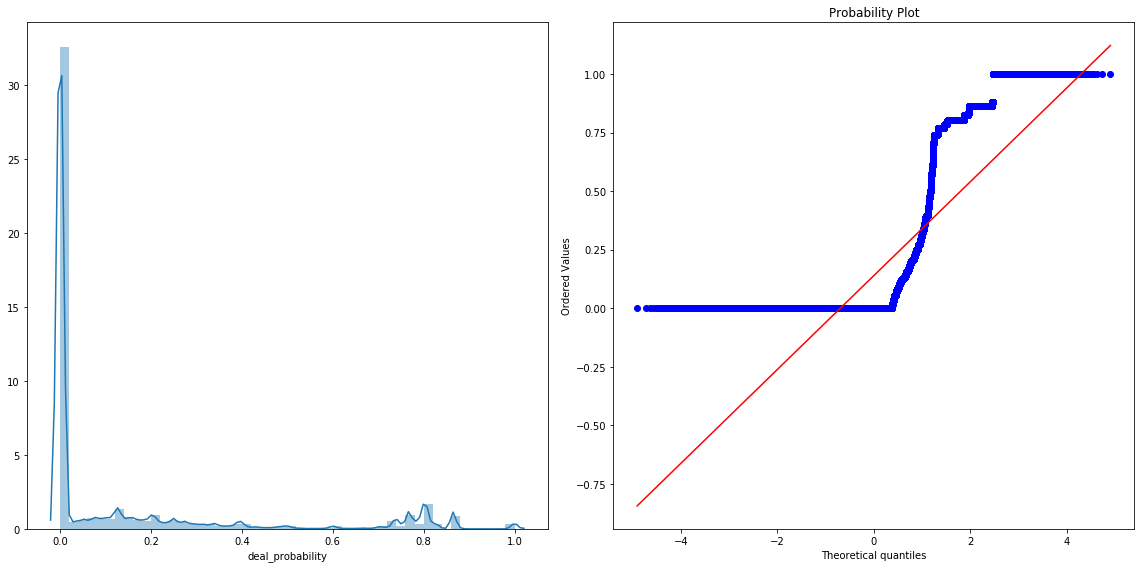

In [13]:
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.distplot(target)
plt.subplot(122)
stats.probplot(target, plot=plt)
plt.tight_layout()
plt.show()

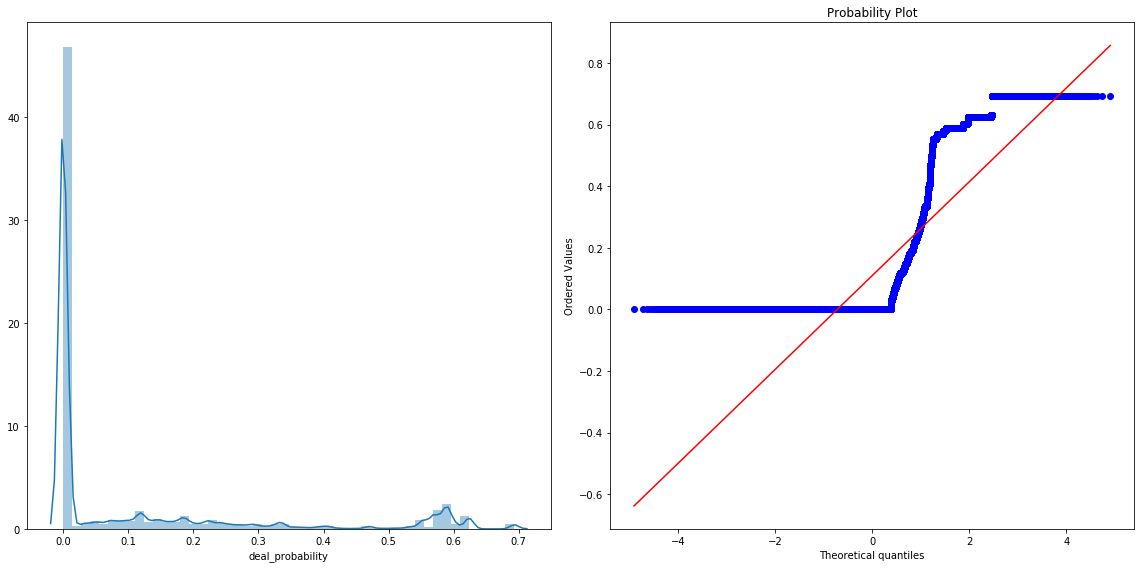

In [14]:
#logigramatic trip duration data#logigra 
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.distplot(np.log(target + 1))
plt.subplot(122)
stats.probplot(np.log(target + 1), plot=plt)
plt.tight_layout()
plt.show()

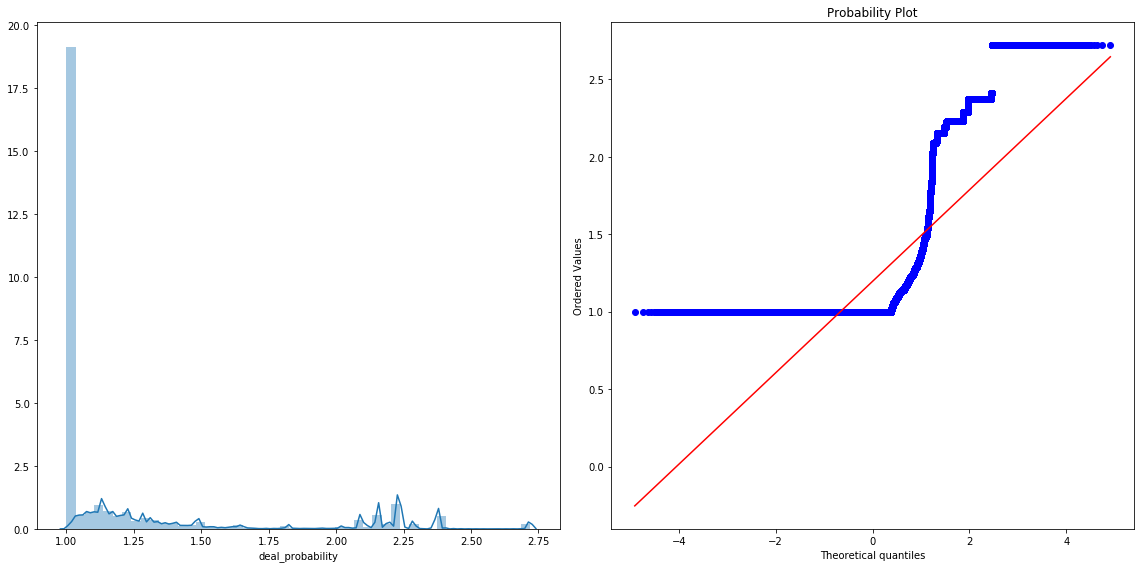

In [15]:
#logigramatic trip duration data#logigra 
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.distplot(np.exp(target))
plt.subplot(122)
stats.probplot(np.exp(target), plot=plt)
plt.tight_layout()
plt.show()

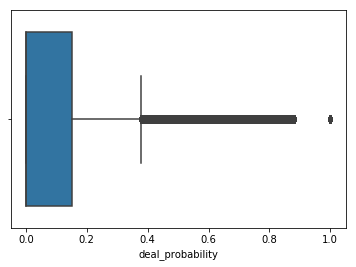

In [16]:
sns.boxplot(x=target, )
plt.show()

In [17]:
print("0 deal probability : ", round(len(target[target == 0]) / len(target), 2))
print("1 deal probability : ", round(len(target[target == 1]) / len(target), 2))

0 deal probability :  0.65
1 deal probability :  0.01


# categorical data list counts

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null object
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
dtypes: float64(3), int

# region

# of category :  28


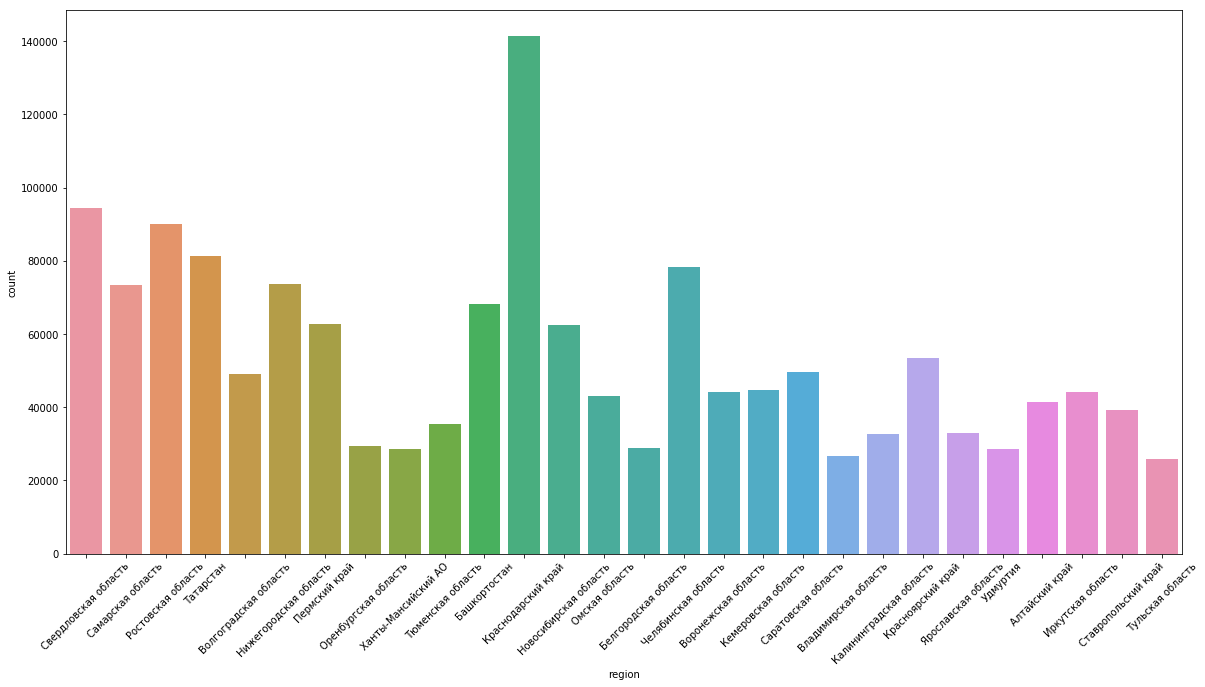

In [52]:
print('# of category : ', len(df_train.region.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_train.region, data=df_train)
plt.show()

# city

# of category :  1733


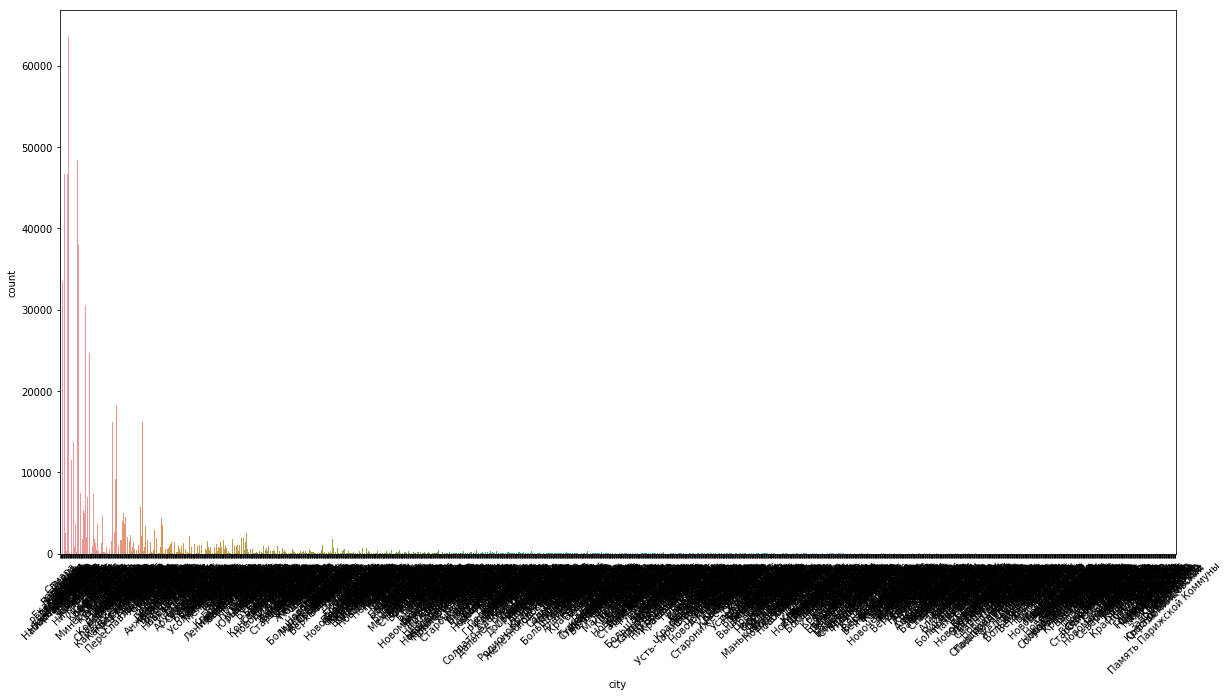

In [53]:
print('# of category : ', len(df_train.city.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_train.city, data=df_train)
plt.show()

# parent_category_name

# of category :  9


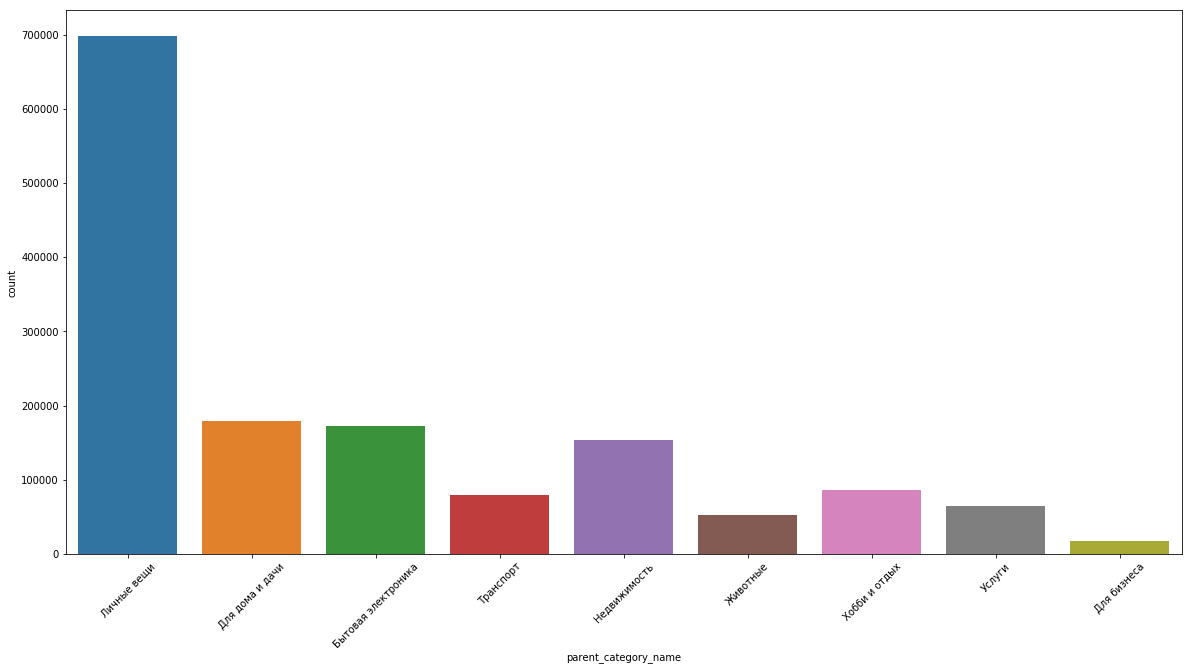

In [54]:
print('# of category : ', len(df_train.parent_category_name.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_train.parent_category_name, data=df_train)
plt.show()

# category_name

# of category :  47


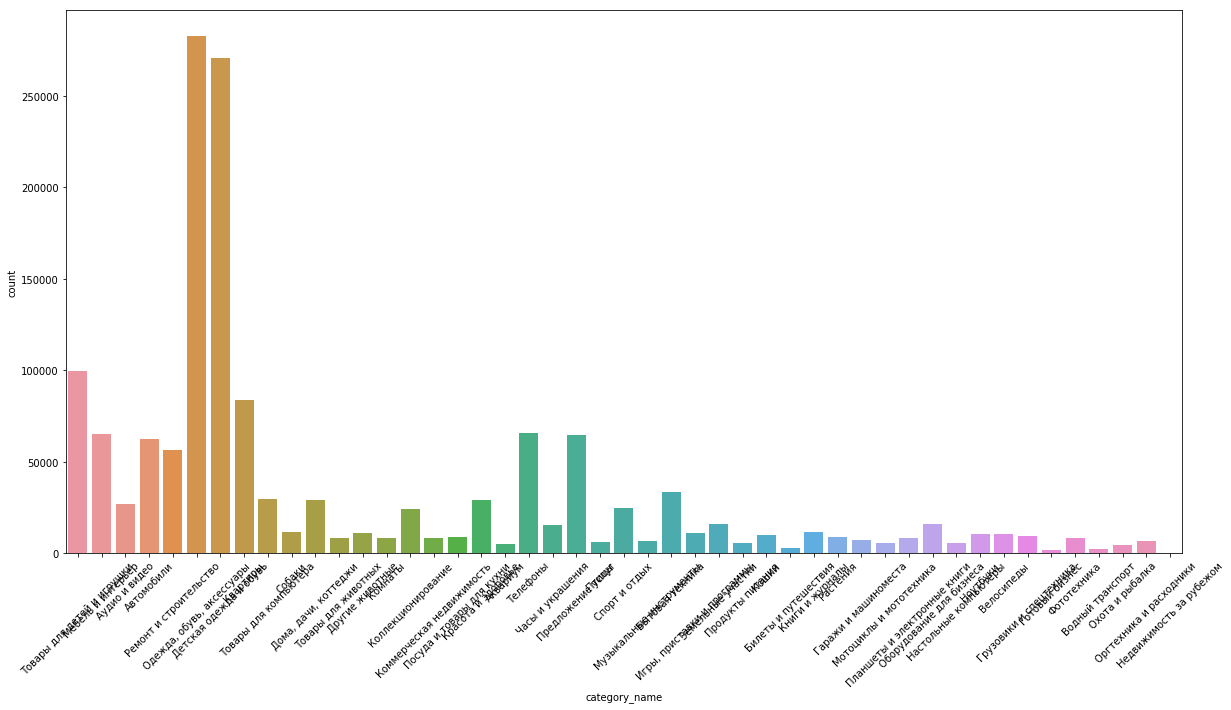

In [55]:
print('# of category : ', len(df_train.category_name.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_train.category_name, data=df_train)
plt.show()

# param_1

# of category :  371


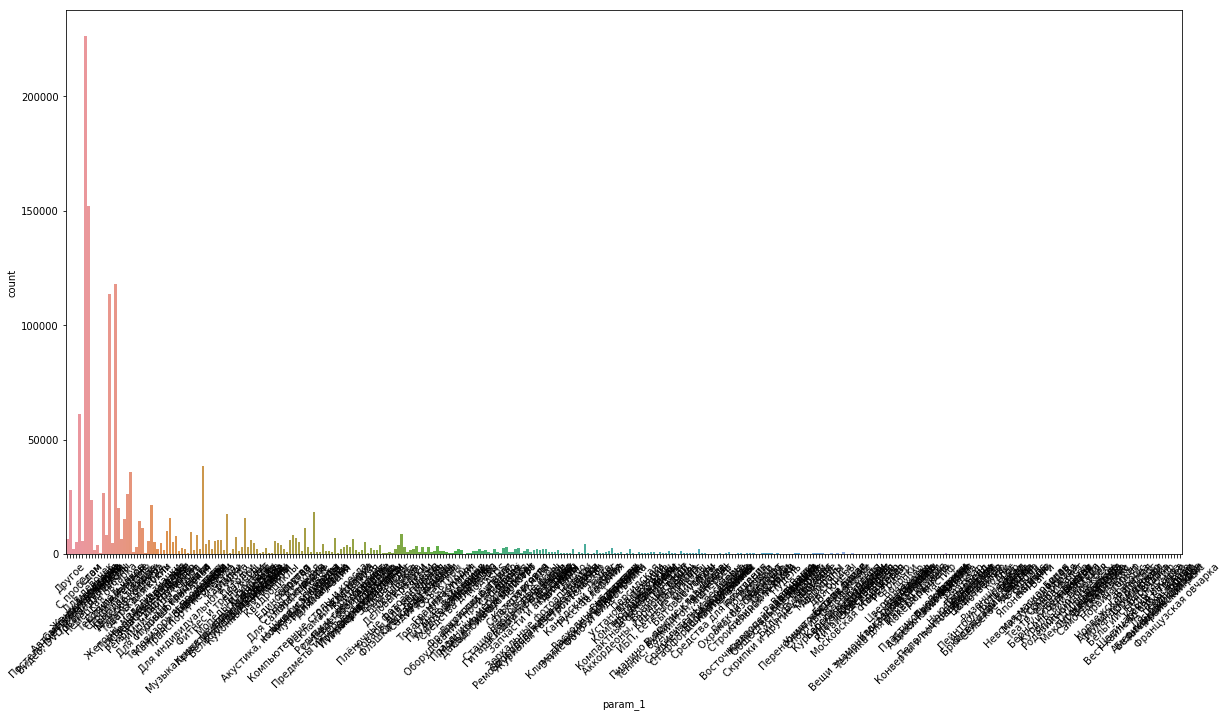

In [56]:
print('# of category : ', len(df_train.param_1.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_train.param_1, data=df_train)
plt.show()

# param_2

# of category :  271


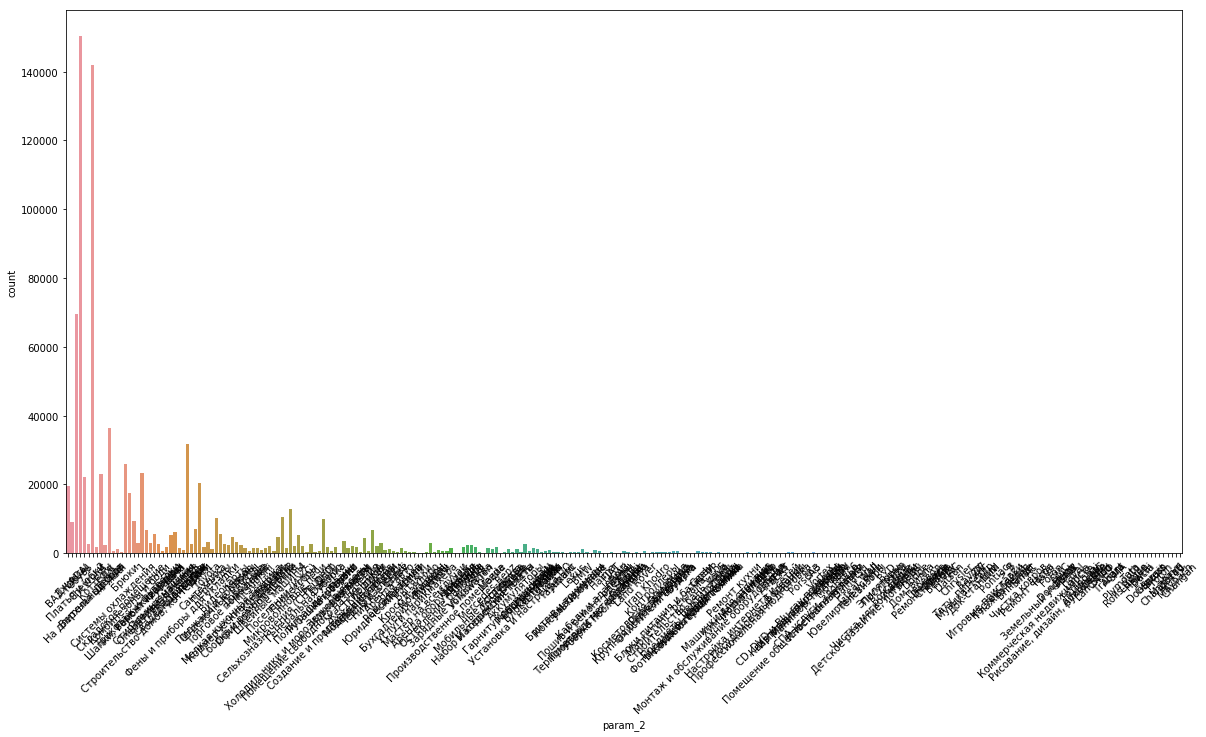

In [57]:
print('# of category : ', len(df_train.param_2.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_train.param_2, data=df_train)
plt.show()

# param_3

# of category :  1219


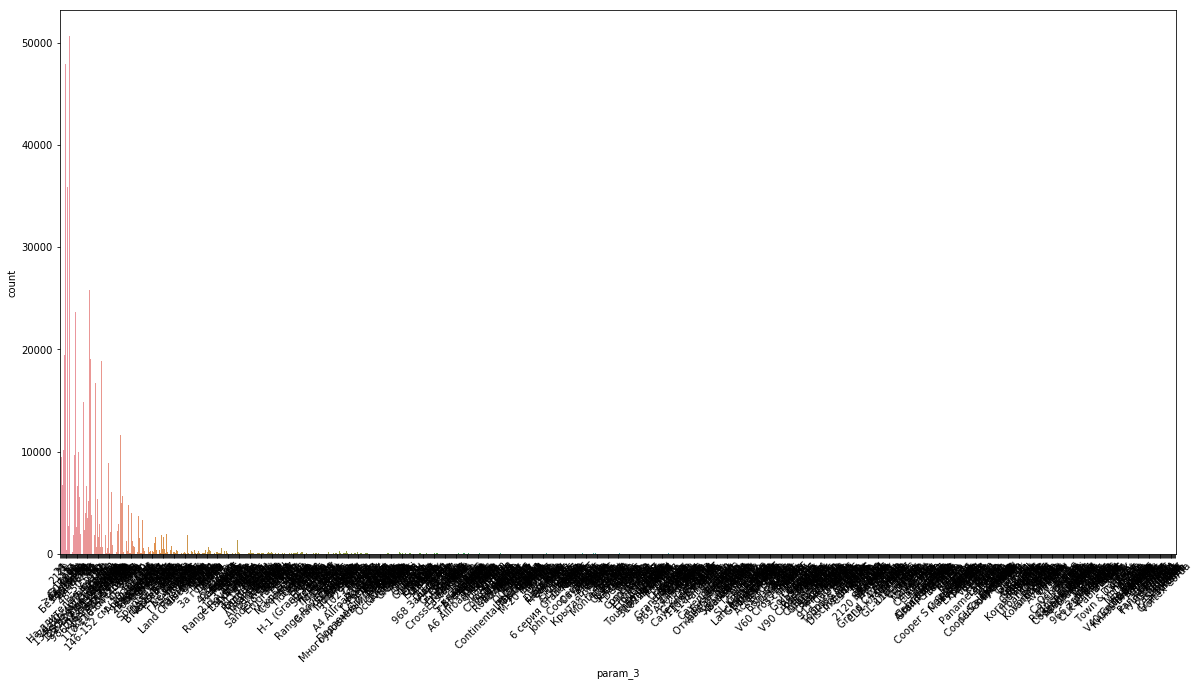

In [58]:
print('# of category : ', len(df_train.param_3.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_train.param_3, data=df_train)
plt.show()

# item_seq_number

# of category :  28232


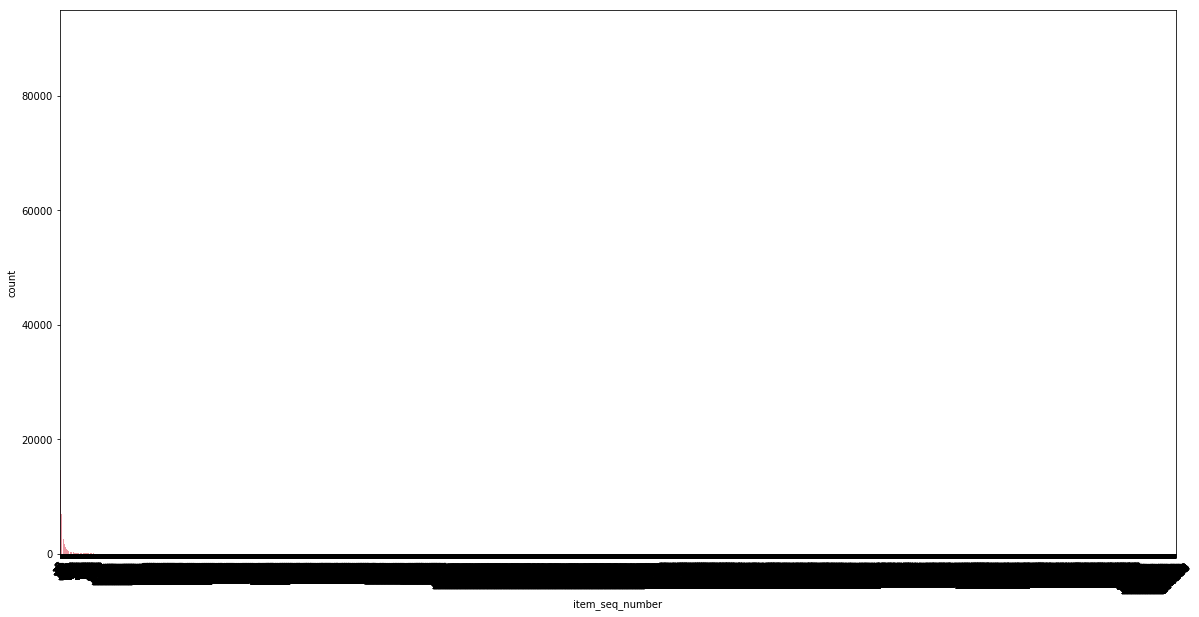

In [59]:
print('# of category : ', len(df_train.item_seq_number.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_train.item_seq_number, data=df_train)
plt.show()

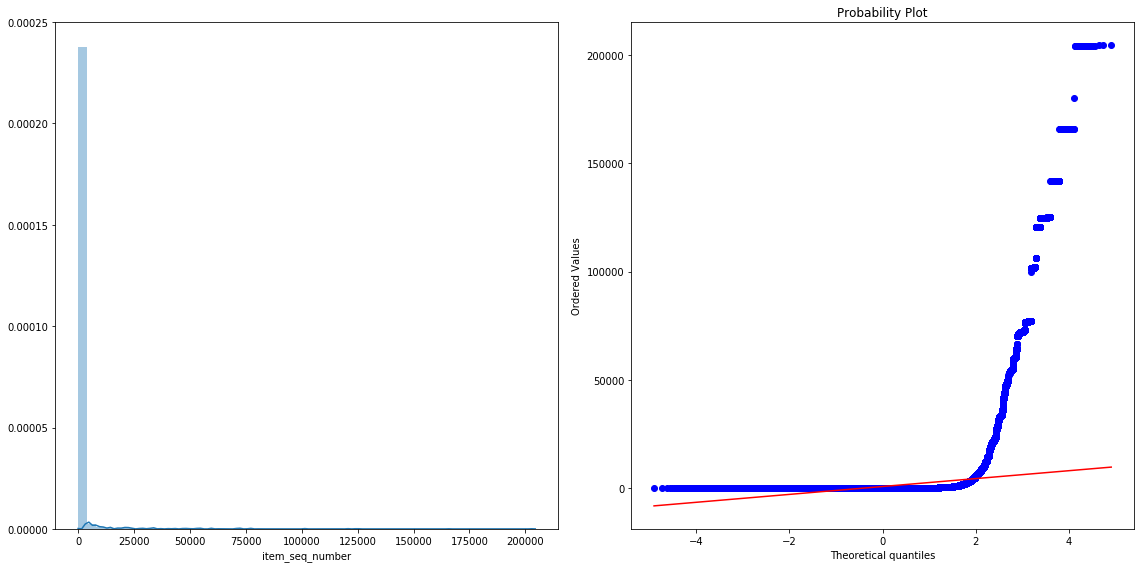

In [62]:
#logigramatic trip duration data#logigra 
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.distplot(df_train.item_seq_number.dropna())
plt.subplot(122)
stats.probplot(df_train.item_seq_number.dropna(), plot=plt)
plt.tight_layout()
plt.show()

# user_type

# of category :  3


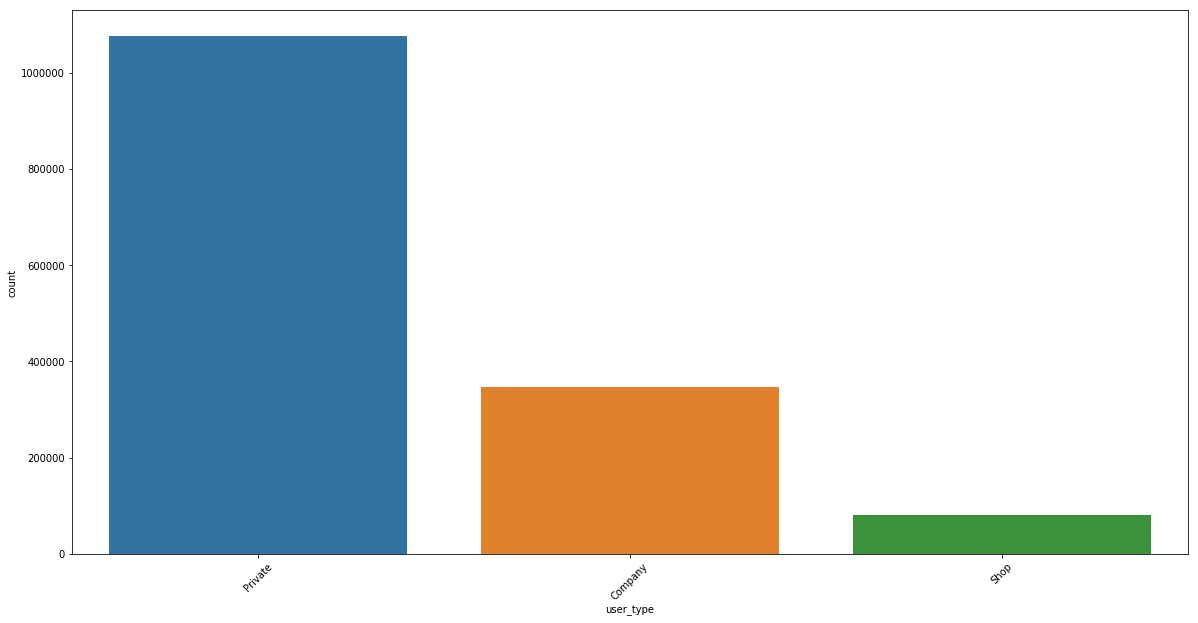

In [60]:
print('# of category : ', len(df_train.user_type.value_counts()))
plt.figure(figsize=(20,10))
plt.xticks(rotation=45)
sns.countplot(x=df_train.user_type, data=df_train)
plt.show()

# price

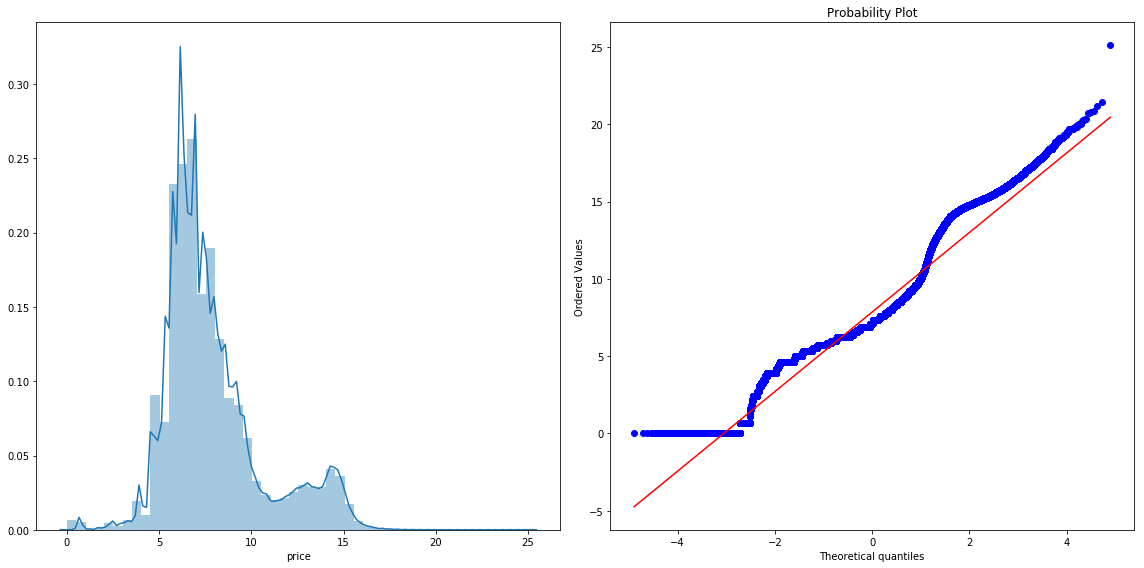

In [30]:
#logigramatic trip duration data#logigra 
plt.figure(figsize=(16,8))
plt.subplot(121)
sns.distplot(np.log(df_train.price.dropna() + 1))
plt.subplot(122)
stats.probplot(np.log(df_train.price.dropna() + 1), plot=plt)
plt.tight_layout()
plt.show()

# missing values

In [31]:
df_train.isnull().sum()

item_id                      0
user_id                      0
region                       0
city                         0
parent_category_name         0
category_name                0
param_1                  61576
param_2                 654542
param_3                 862565
title                        0
description             116276
price                    85362
item_seq_number              0
activation_date              0
user_type                    0
image                   112588
image_top_1             112588
deal_probability             0
dtype: int64

In [32]:
print('param_1     :', round(df_train.param_1.isnull().sum() / len(df_train), 2))
print('param_2     :', round(df_train.param_2.isnull().sum() / len(df_train), 2))
print('param_3     :', round(df_train.param_3.isnull().sum() / len(df_train), 2))
print('description :', round(df_train.description.isnull().sum() / len(df_train), 2))
print('price       :', round(df_train.price.isnull().sum() / len(df_train), 2))
print('image       :', round(df_train.image.isnull().sum() / len(df_train), 2))
print('image_top_1 :', round(df_train.image_top_1.isnull().sum() / len(df_train), 2))

param_1     : 0.04
param_2     : 0.44
param_3     : 0.57
description : 0.08
price       : 0.06
image       : 0.07
image_top_1 : 0.07


In [34]:
df_train.price.median()

1300.0

# language translate by googletrans

In [35]:
from googletrans import Translator
translator = Translator()

In [37]:
new = df_train.copy()

In [38]:
para = "parent_category_name"

before = df_train[para].value_counts().index.astype(str)
after = []

print(len(before))

for i in range(len(before)):
    translator = Translator()
    temp = translator.translate(before[i]).text
    after.append(temp)
    
zip_para = dict(zip(before, after))

new[para] = new[para].replace(to_replace=zip_para)

9


In [39]:
para = "category_name"

before = df_train[para].value_counts().index.astype(str)
after = []

print(len(before))

for i in range(len(before)):
    translator = Translator()
    temp = translator.translate(before[i]).text
    after.append(temp)
    
zip_para = dict(zip(before, after))

new[para] = new[para].replace(to_replace=zip_para)

47


In [40]:
para = "param_1"

before = df_train[para].value_counts().index.astype(str)
after = []

print(len(before))

for i in range(len(before)):
    translator = Translator()
    temp = translator.translate(before[i]).text
    after.append(temp)
    
zip_para = dict(zip(before, after))

new[para] = new[para].replace(to_replace=zip_para)

371


In [41]:
para = "param_2"

before = df_train[para].value_counts().index.astype(str)
after = []

print(len(before))

for i in range(len(before)):
    translator = Translator()
    temp = translator.translate(before[i]).text
    after.append(temp)
    
zip_para = dict(zip(before, after))

new[para] = new[para].replace(to_replace=zip_para)

271


In [42]:
para = "param_3"

before = df_train[para].value_counts().index.astype(str)
after = []

print(len(before))

for i in range(len(before)):
    translator = Translator()
    temp = translator.translate(before[i]).text
    after.append(temp)
    
zip_para = dict(zip(before, after))

new[para] = new[para].replace(to_replace=zip_para)

1219


In [ ]:
new.head()

In [43]:
gc.collect()

3230638

In [61]:
paras = ['parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3', 'title', 'description']
df1 = pd.DataFrame(columns=paras)

for para in paras:
    
    after = []
    
    for i in range(7,11):
        translator = Translator()
        temp = translator.translate(df_train[para][i]).text
        after.append(temp)
    df1[para] = after
        
df1

,parent_category_name,category_name,param_1,param_2,param_3,title,description
0,Personal things,"Clothes, shoes, accessories",Women's clothing,Jeans,26,Boyfriends colins,Boyfriends in good condition.
1,Personal things,"Clothes, shoes, accessories",Women's clothing,Dresses and skirts,> 50 (XXL),Dress,54 times very convenient
2,Personal things,Children's clothing and footwear,For girls,Footwear,25,Half botinchka zamš natur.Bambini,On the insole 15.5cm measure the Prioksky area...
3,The property,Apartments,Rent,For a long time,1,"1-to the apartment, 25 m ², 2/2 fl.",One bedroom furnished apartment for rent. The ...


In [66]:
paras = ['parent_category_name', 'category_name', 'param_1', 'param_2', 'param_3', 'title', 'description']
df2 = pd.DataFrame(columns=paras)

for para in paras:
    
    after = []
    
    for i in range(18,23):
        translator = Translator()
        temp = translator.translate(df_train[para][i]).text
        after.append(temp)
    df2[para] = after
        
df2

,parent_category_name,category_name,param_1,param_2,param_3,title,description
0,Personal things,"Clothes, shoes, accessories",Women's clothing,Outerwear,44–46 (M),Spring jacket (autumn),"The jacket is new, very comfortable, the price..."
1,The property,"Houses, cottages, cottages",Hire,Cottage,For a long time,Hire a cottage,A married couple of two people will remove the...
2,The property,Apartments,Selling,2,Secondary,"2-to the apartment, 44 m ², 5/5 fl.",The house is located inside the block.\nPlasti...
3,Personal things,"Clothes, shoes, accessories",Women's clothing,Outerwear,> 50 (XXL),Hat norwokaya,"Selling a hat, mink, brown color, in excellent..."
4,Transport,Cars,With mileage,Ford,Focus,"Ford Focus, 2005",Full set. GUR. 4 esp. Heated seats of rear-vie...


# date time convert

In [67]:
df_train["activation_date"] = pd.to_datetime(df_train["activation_date"], format = "%Y-%m-%d")

In [68]:
df_train['active_year'] = df_train["activation_date"].apply(lambda x : x.year)
df_train['active_month'] = df_train["activation_date"].apply(lambda x : x.month)
df_train['active_day'] = df_train["activation_date"].apply(lambda x : x.day)

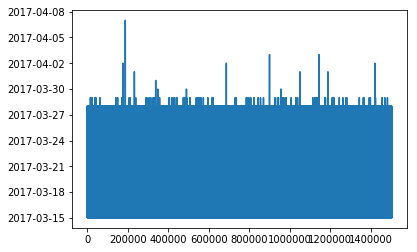

In [81]:
# df3 = pd.DataFrame(randn(1000, 2), columns=['B', 'C']).cumsum()
# df3['A'] = Series(list(range(len(df))))
df_train.activation_date.plot()

# Tf-idf